# **Thư viện**

In [1]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import train_test_split

## **Drive**

# **Đọc bộ dữ liệu**

In [ ]:
file_path = 'combined.csv'

raw_df = pd.read_csv(file_path, encoding='utf-8')
raw_df.head()

,content,summary
0,Thủ tướng Nguyễn Xuân Phúc và Bộ trưởng Ngoại ...,Thủ tướng Nguyễn Xuân Phúc và Bộ trưởng Ngoại ...
1,"Suốt bao năm, để dòng tranh này không bị rơi v...",Ông Đạt Trần Thành là một trong những nghệ nhâ...
2,Khách qua phà mê mải ngắm sông như muốn quên đ...,Những người thường ra bờ sông Sài Gòn để hóng ...
3,"Trong thông báo gửi cổ đông ngày 22/4, CTCP Nh...",CTCP Nhiệt điện Phả Lại (PPC) và CTCP Nhiệt đi...
4,Theo Al Masdar News dẫn nguồn tin sáng 25/8 ch...,Quân đội Syria và Lực lượng Phòng vệ Quốc gia ...


# **Tổng quan về bộ dữ liệu**

## **Số dòng, số cột:**


In [ ]:
raw_df.shape

(66361, 2)

# **Dữ liệu thiếu**



In [ ]:
raw_df.isna().sum()

,0
content,0
summary,1038


Bỏ các sample thiếu ở trường `summary`

In [ ]:
raw_df = raw_df.dropna(subset=['summary'])
raw_df.isna().sum()

,0
content,0
summary,0


# **Trùng lặp**

In [ ]:
raw_df.duplicated().sum()

np.int64(80)

In [ ]:
raw_df.drop_duplicates(inplace=True)
raw_df.shape

(65243, 2)

# **Segmentation**

In [ ]:
!pip install underthesea

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 65.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 49.9 MB/s eta 0:00:00


In [ ]:
from underthesea import word_tokenize

def segment_text(text):
  return word_tokenize(text, format="text")

In [ ]:
raw_df['content'] = raw_df['content'].apply(segment_text)

In [ ]:
raw_df['summary'] = raw_df['summary'].apply(segment_text)

# **Chuẩn hóa giá trị**

Chúng ta sẽ xóa các giá trị đặc biệt như: \n, \t, \r ...

In [ ]:
raw_df['content'] = raw_df['content'].str.replace(r'[\n\t\r]', ' ', regex=True)
raw_df['summary'] = raw_df['summary'].str.replace(r'[\n\t\r]', ' ', regex=True)

Bỏ một số từ không cần thiết.
Ví dụ: ghi chú ảnh ...

In [ ]:
raw_df['content'] = raw_df['content'].str.replace(r"\( Ảnh:.*?\)", "", regex=True).str.strip()
raw_df['summary'] = raw_df['summary'].str.replace(r"\( Ảnh:.*?\)", "", regex=True).str.strip()

Phân bố số từ

In [ ]:
raw_df['content_num_words'] = raw_df['content'].apply(lambda text: len(text.split()))
raw_df['summary_num_words'] = raw_df['summary'].apply(lambda text: len(text.split()))
raw_df.describe()

,content_num_words,summary_num_words
count,65243.000000,65243.000000
mean,363.106019,95.015051
std,197.899105,39.060541
min,7.000000,2.000000
25%,207.000000,70.000000
50%,323.000000,89.000000
75%,496.000000,113.000000
max,1179.000000,443.000000


In [ ]:
raw_df = raw_df[raw_df['content'].apply(lambda x: len(x.split())) <= 1000]
raw_df.describe()

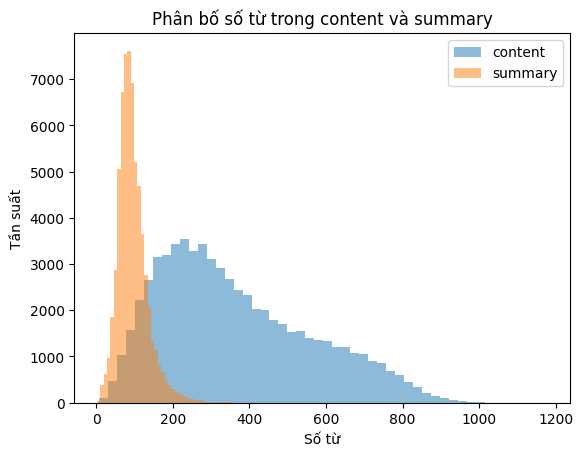

In [ ]:
plt.hist(raw_df['content_num_words'], bins=50, alpha=0.5, label='content')
plt.hist(raw_df['summary_num_words'], bins=50, alpha=0.5, label='summary')
plt.legend(loc='upper right')
plt.title('Phân bố số từ trong content và summary')
plt.xlabel('Số từ')
plt.ylabel('Tần suất')
plt.show()

In [ ]:
raw_df.to_csv('/content/drive/MyDrive/data/cleaned_data.csv', index=False, encoding='utf-8')

raw_df.sample(5)

,content,summary,content_num_words,summary_num_words
39783,"Mới_đây , tại Triển_lãm mô_tô xe_máy Việt_Nam ...",Triển_lãm mô_tô xe_máy Việt_Nam 2017 là sự hội...,591,83
54866,"- Sau khi đọc các bài : Đáy nào cho BĐS ? , Đá...","Sau khi đọc các bài báo về đáy BĐS , nhiều bạn...",889,40
3515,Theo báo_cáo của Bộ_trưởng Bộ Công_an Trần_Đại...,"Năm 2015 , Bộ_trưởng Bộ Công_an Trần_Đại_Quang...",571,115
10837,Thái_Bình Ruộng lúa ở Phillippines_năng_suất t...,Philippines thường_xuyên phải nhập_khẩu lương_...,493,150
58519,GPBank sắp ngã giá_thành_công . Trong Chương_t...,GPBank có xác_suất thành_công cao trong việc b...,686,93


# **Phân cụm nội dung**

In [2]:
df = pd.read_csv('cleaned_data.csv', encoding='utf-8')
df.head()

,content,summary,content_num_words,summary_num_words
0,Thủ_tướng Nguyễn_Xuân_Phúc và Bộ_trưởng Ngoại_...,Thủ_tướng Nguyễn_Xuân_Phúc và Bộ_trưởng Ngoại_...,433,99
1,"Suốt bao năm , để dòng tranh này không bị rơi ...",Ông Đạt Trần_Thành là một trong những nghệ_nhâ...,720,118
2,Khách qua phà mê_mải ngắm sông như muốn quên đ...,Những người thường ra bờ sông Sài_Gòn để hóng ...,292,79
3,"Trong thông_báo gửi cổ_đông ngày 22/4 , CTCP N...",CTCP Nhiệt_điện Phả_Lại ( PPC ) và CTCP Nhiệt_...,405,99
4,Theo Al Masdar_News dẫn nguồn tin sáng 25/8 ch...,Quân_đội Syria và Lực_lượng Phòng_vệ Quốc_gia ...,239,91


count    65228.000000
mean         0.696474
std          0.127788
min          0.002584
25%          0.627657
50%          0.713786
75%          0.785562
max          0.997888
Name: cosine_similarity, dtype: float64


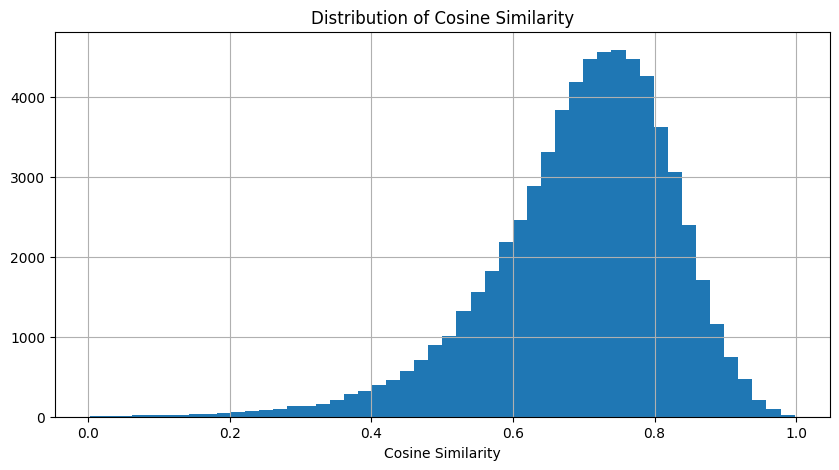

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

vectorizer = TfidfVectorizer(
    tokenizer=lambda text: text.split(),
    lowercase=False,
    token_pattern=None
)
tfidf_content = vectorizer.fit_transform(df['content'])
tfidf_summary = vectorizer.transform(df['summary'])

dot_products = tfidf_content.multiply(tfidf_summary).sum(axis=1).A1
content_norm = np.sqrt(tfidf_content.multiply(tfidf_content).sum(axis=1).A1)
summary_norm = np.sqrt(tfidf_summary.multiply(tfidf_summary).sum(axis=1).A1)

df['cosine_similarity'] = dot_products / (content_norm * summary_norm + 1e-10)

print(df['cosine_similarity'].describe())
df['cosine_similarity'].hist(bins=50, figsize=(10,5))
plt.title('Distribution of Cosine Similarity')
plt.xlabel('Cosine Similarity')
plt.show()

Số mẫu còn lại sau khi lọc: 45494
count    45494.000000
mean         0.762256
std          0.068514
min          0.650006
25%          0.706929
50%          0.756331
75%          0.809939
max          0.997819
Name: cosine_similarity, dtype: float64


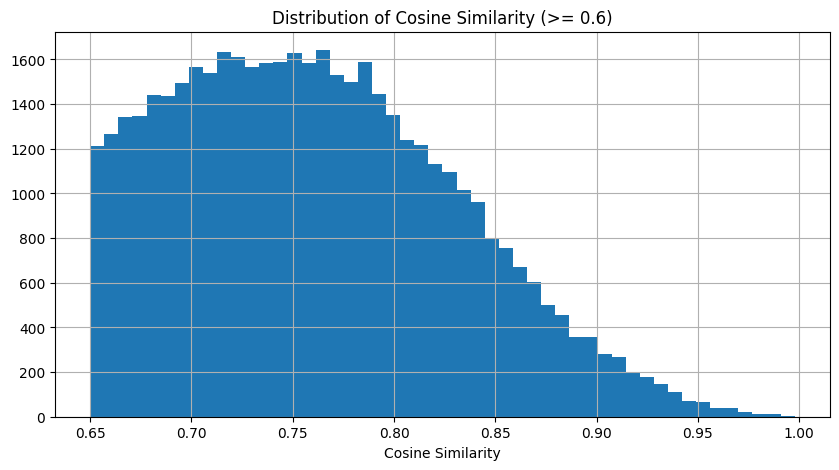

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

vectorizer = TfidfVectorizer(
    tokenizer=lambda text: text.split(),
    lowercase=False,
    token_pattern=None
)
tfidf_content = vectorizer.fit_transform(df['content'])
tfidf_summary = vectorizer.transform(df['summary'])

dot_products = tfidf_content.multiply(tfidf_summary).sum(axis=1).A1
content_norm = np.sqrt(tfidf_content.multiply(tfidf_content).sum(axis=1).A1)
summary_norm = np.sqrt(tfidf_summary.multiply(tfidf_summary).sum(axis=1).A1)

df['cosine_similarity'] = dot_products / (content_norm * summary_norm + 1e-10)
df = df[df['cosine_similarity'] >= 0.65]
print(f"Số mẫu còn lại sau khi lọc: {df.shape[0]}")

print(df['cosine_similarity'].describe())
df['cosine_similarity'].hist(bins=50, figsize=(10,5))
plt.title('Distribution of Cosine Similarity (>= 0.6)')
plt.xlabel('Cosine Similarity')
plt.show()

In [13]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X = vectorizer.fit_transform(df['content'])

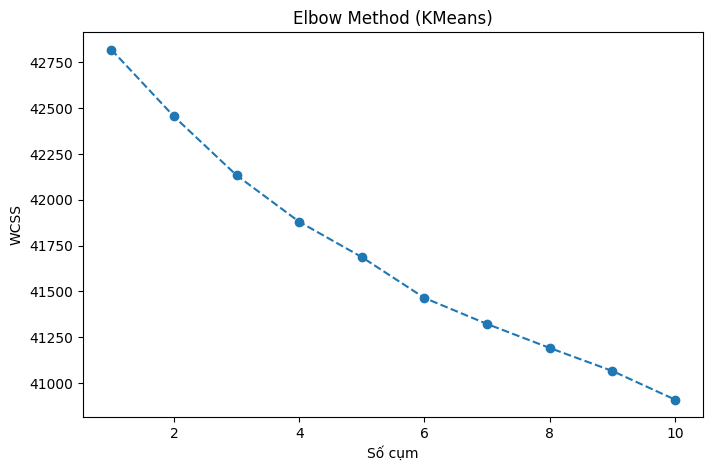

In [14]:
from sklearn.cluster import KMeans

# Tính WCSS
wcss = []
for n_clusters in range(1, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Elbow method
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.xlabel('Số cụm')
plt.ylabel('WCSS')
plt.title('Elbow Method (KMeans)')
plt.show()

In [15]:
# Phân cụm
n_clusters = 3
kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, batch_size=1000)
df['cluster'] = kmeans.fit_predict(X)

df['cluster'].value_counts()

cluster
2    21804
1    17093
0     6597
Name: count, dtype: int64

In [17]:
#df = df.drop(columns=['content_num_words', 'summary_num_words'])
df.sample(5)

,content,summary,cosine_similarity,cluster
9652,Cô Antonia_Montenegro trong thời_gian nằm viện...,Cô Antonia_Montenegro đã sinh 5 bé gái và bé t...,0.706719,2
2598,Giá vàng thế_giới trên sàn New_York đêm qua tă...,Giá vàng trên sàn New_York đã tăng mạnh lên mứ...,0.789133,0
63579,Binh_sỹ chính_phủ Syria chiến_đấu tại tỉnh Lat...,Quân_đội Syria với sự trợ_giúp của không_quân ...,0.711512,2
51454,Gần 100 vụ vi_phạm của Uber và Grab . Ảnh : CE...,Gần 100 vụ vi_phạm liên_quan đến hoạt_động kin...,0.739242,1
5089,"Tuy_nhiên , theo tác_giả , chí_ít là từ nay đế...","Tác_giả Menman cho rằng , cuộc_chiến giữa Isra...",0.685501,2


In [18]:
df.to_csv('clustered_data.csv', index=False, encoding='utf-8')

In [19]:
train_df, temp_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['cluster']
)
valid_df, test_df = train_test_split(
    temp_df, test_size=0.5, random_state=42, stratify=temp_df['cluster']
)

print("Train size:", len(train_df))
print("Validation size:", len(valid_df))
print("Test size:", len(test_df))

Train size: 36395
Validation size: 4549
Test size: 4550


In [20]:
train_df.to_csv('train1.csv', index=False, encoding='utf-8')
valid_df.to_csv('valid1.csv', index=False, encoding='utf-8')
test_df.to_csv('test1.csv', index=False, encoding='utf-8')